In [40]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [29]:
# Open the NetCDF file
file_path = 'G:/Other computers/My MacBook Air/Documents/School/MEnvSc/UTCDW Hackathon/TerraClimate.tmax.monthlymean.1980-2010.nc'  
nc_data = xr.open_dataset(file_path)

# Extract longitude and latitude values
EA_lon = nc_data.lon.values
EA_lat = nc_data.lat.values

# Create an xarray Dataset with lon and lat as coordinates
coords = {'lon': EA_lon, 'lat': EA_lat}
coords_ds = xr.Dataset(coords=coords)

# Convert the calendar if needed (optional)
#coords_ds_noleap = convert_calendar(coords_ds, 'noleap')

# Access the extracted variables if needed (optional)
#tas_obs_noleap = coords_ds_noleap.tas

# Display the coordinates dataset
print(coords_ds)

<xarray.Dataset> Size: 1kB
Dimensions:  (lon: 60, lat: 120)
Coordinates:
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
Data variables:
    *empty*


In [30]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [31]:
df_ta = df.query("table_id == 'Amon' & source_id in ['AWI-CM-1-1-MR', 'CESM2', 'CanESM5', 'EC-Earth3', 'FGOALS-g3', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0'] & variable_id in ['tasmax'] & experiment_id == 'historical' & member_id =='r1i1p1f1'")
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
29232,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tasmax,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
45681,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
55766,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190222
100290,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
206380,CMIP,INM,INM-CM5-0,historical,r1i1p1f1,Amon,tasmax,gr1,gs://cmip6/CMIP6/CMIP/INM/INM-CM5-0/historical...,NaN,20190610
222132,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
254871,CMIP,CAS,FGOALS-g3,historical,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/historical...,NaN,20190818
425600,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,Amon,tasmax,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200310


In [32]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [33]:
# Get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta.zstore.values[0]
print(zstore)

gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tasmax/gr/v20180803/


In [34]:
# Create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# Open it using xarray and zarr
file1 = xr.open_zarr(mapper, consolidated=True)
file1

<xarray.Dataset> Size: 163MB
Dimensions:      (lat: 143, lon: 144, time: 1980, axis_nbounds: 2)
Coordinates:
    height       float64 8B ...
  * lat          (lat) float32 572B -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
  * lon          (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-1...
    time_bounds  (time, axis_nbounds) datetime64[ns] 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    tasmax       (time, lat, lon) float32 163MB dask.array<chunksize=(600, 143, 144), meta=np.ndarray>
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  historical
    NCO:                    "4.6.0"
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/021cae57-1867-4eb2-a646-62cf627a739d
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/021cae57-1867-4eb2-a646-62cf627a739d
    version_id:             v20180803

In [35]:
# Select grid box nearest to the Toronto station latitude and longitude
tasmax_EA = file1.sel(lat= EA_lat, lon= EA_lon,method='nearest')

# Select time range using slicing
tasmax_EA_baseline = tasmax_EA.sel(time=slice("1980","2010")) - 273.15 # convert from Kelvin to degrees Celsius

# Load data. This step might take a minute or two.
tasmax_EA_baseline.load()

<xarray.Dataset> Size: 11MB
Dimensions:      (lat: 120, lon: 60, time: 372, axis_nbounds: 2)
Coordinates:
    height       float64 8B 2.0
  * lat          (lat) float32 480B 16.48 16.48 16.48 ... 11.41 11.41 11.41
  * lon          (lon) float32 240B 32.5 32.5 32.5 32.5 ... 35.0 35.0 35.0 35.0
  * time         (time) datetime64[ns] 3kB 1980-01-16T12:00:00 ... 2010-12-16...
    time_bounds  (time, axis_nbounds) datetime64[ns] 6kB 1980-01-01 ... 2011-...
Dimensions without coordinates: axis_nbounds
Data variables:
    tasmax       (time, lat, lon) float32 11MB 25.69 25.69 25.69 ... 30.33 30.33
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  historical
    NCO:                    "4.6.0"
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/021cae57-1867-4eb2-a646-62cf627a739d
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/021cae57-1867-4eb2-a646-62cf627a739d
    version_id:             v20180803

In [36]:
tasmax_EA_mm = tasmax_EA_baseline.tasmax.groupby('time.month').mean('time').compute()
tasmax_EA_mm

<xarray.DataArray 'tasmax' (month: 12, lat: 120, lon: 60)> Size: 346kB
array([[[26.800379, 26.800379, 26.800379, ..., 28.411999, 28.411999,
         28.411999],
        [26.800379, 26.800379, 26.800379, ..., 28.411999, 28.411999,
         28.411999],
        [26.800379, 26.800379, 26.800379, ..., 28.411999, 28.411999,
         28.411999],
        ...,
        [31.983395, 31.983395, 31.983395, ..., 30.95402 , 30.95402 ,
         30.95402 ],
        [31.983395, 31.983395, 31.983395, ..., 30.95402 , 30.95402 ,
         30.95402 ],
        [31.983395, 31.983395, 31.983395, ..., 30.95402 , 30.95402 ,
         30.95402 ]],

       [[28.214138, 28.214138, 28.214138, ..., 29.87247 , 29.87247 ,
         29.87247 ],
        [28.214138, 28.214138, 28.214138, ..., 29.87247 , 29.87247 ,
         29.87247 ],
        [28.214138, 28.214138, 28.214138, ..., 29.87247 , 29.87247 ,
         29.87247 ],
...
        [32.374443, 32.374443, 32.374443, ..., 29.905146, 29.905146,
         29.905146],
        [32.374443, 32.374443, 32.374443, ..., 29.905146, 29.905146,
         29.905146],
        [32.374443, 32.374443, 32.374443, ..., 29.905146, 29.905146,
         29.905146]],

       [[26.575794, 26.575794, 26.575794, ..., 28.225077, 28.225077,
         28.225077],
        [26.575794, 26.575794, 26.575794, ..., 28.225077, 28.225077,
         28.225077],
        [26.575794, 26.575794, 26.575794, ..., 28.225077, 28.225077,
         28.225077],
        ...,
        [31.303389, 31.303389, 31.303389, ..., 29.867128, 29.867128,
         29.867128],
        [31.303389, 31.303389, 31.303389, ..., 29.867128, 29.867128,
         29.867128],
        [31.303389, 31.303389, 31.303389, ..., 29.867128, 29.867128,
         29.867128]]], dtype=float32)
Coordinates:
    height   float64 8B 2.0
  * lat      (lat) float32 480B 16.48 16.48 16.48 16.48 ... 11.41 11.41 11.41
  * lon      (lon) float32 240B 32.5 32.5 32.5 32.5 32.5 ... 35.0 35.0 35.0 35.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [37]:
time_idx = 0
tasmax_at_time = tasmax_EA_baseline['tasmax'].isel(time=time_idx)
tasmax_at_time

<xarray.DataArray 'tasmax' (lat: 120, lon: 60)> Size: 29kB
array([[25.692993, 25.692993, 25.692993, ..., 28.254364, 28.254364,
        28.254364],
       [25.692993, 25.692993, 25.692993, ..., 28.254364, 28.254364,
        28.254364],
       [25.692993, 25.692993, 25.692993, ..., 28.254364, 28.254364,
        28.254364],
       ...,
       [31.961945, 31.961945, 31.961945, ..., 31.433014, 31.433014,
        31.433014],
       [31.961945, 31.961945, 31.961945, ..., 31.433014, 31.433014,
        31.433014],
       [31.961945, 31.961945, 31.961945, ..., 31.433014, 31.433014,
        31.433014]], dtype=float32)
Coordinates:
    height   float64 8B 2.0
  * lat      (lat) float32 480B 16.48 16.48 16.48 16.48 ... 11.41 11.41 11.41
  * lon      (lon) float32 240B 32.5 32.5 32.5 32.5 32.5 ... 35.0 35.0 35.0 35.0
    time     datetime64[ns] 8B 1980-01-16T12:00:00

TypeError: Input z must be 2D, not 3D

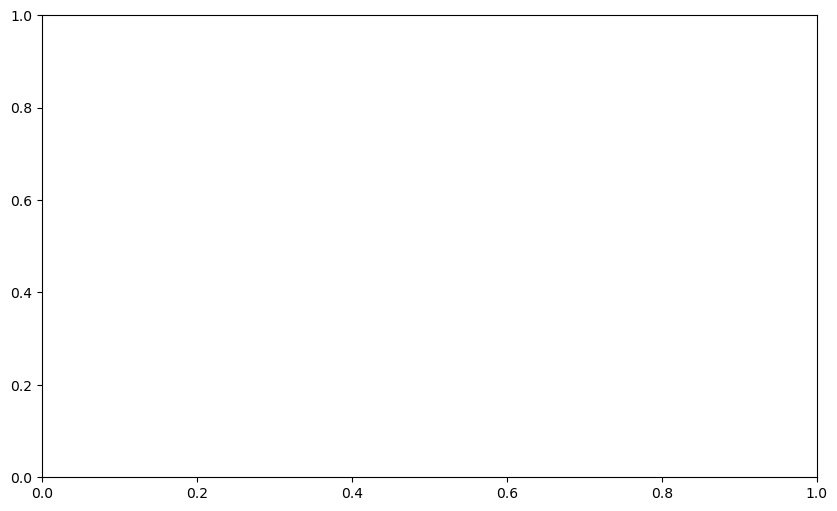

In [38]:
import matplotlib.pyplot as plt
import xarray as xr

# Assuming 'ds' is your xarray Dataset containing the 'tasmax' variable
# Replace 'ds' with your actual Dataset variable

# Select a specific time index for plotting, e.g., the first time step
# time_idx = 0
# tasmax_at_time = tasmax_EA_baseline['tasmax'].isel(time=time_idx)

# Create the plot using matplotlib's contourf function
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.contourf(tasmax_EA_mm[0].lon, tasmax_EA_mm[0].lat, tasmax_EA_mm, levels=20, cmap='coolwarm')  # Adjust colormap and levels as needed
plt.colorbar(label='tasmax (°C)')  # Add colorbar with label
plt.title('tasmax at a Specific Time Index')  # Add title
plt.xlabel('Longitude')  # Add x-axis label
plt.ylabel('Latitude')  # Add y-axis label
plt.grid(True)  # Add grid lines
plt.show()


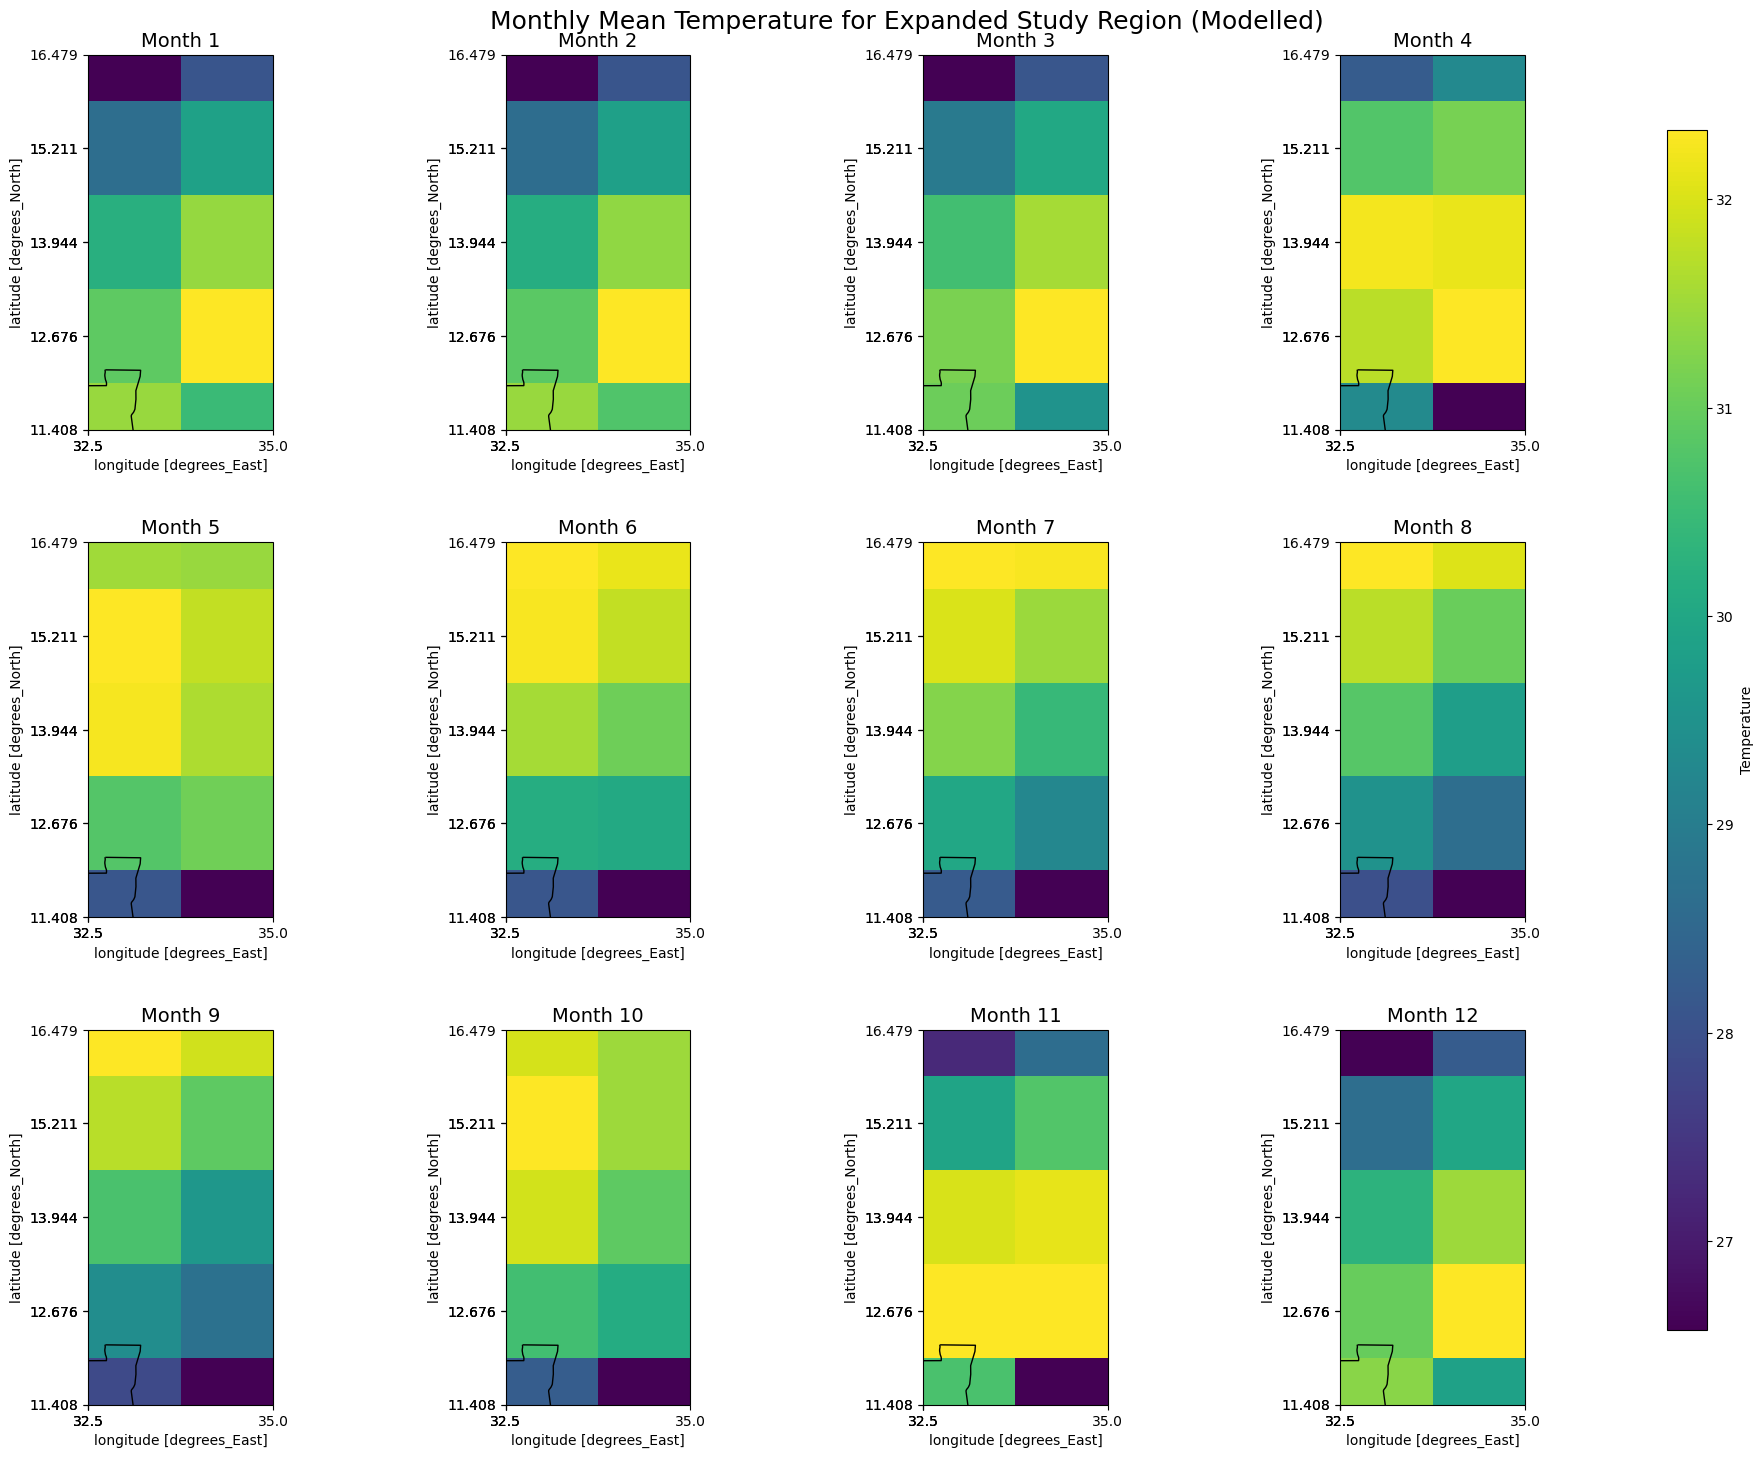

In [42]:
# Define the number of rows and columns
num_rows = 3
num_cols = 4

# Plotting
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15), subplot_kw=dict(projection=ccrs.PlateCarree()))

t_mean_month = []
# Loop through the rows and columns
for row in range(num_rows):
    for col in range(num_cols):
        month_index = row * num_cols + col + 1  # Calculate the month index
        if month_index <= 12:  # Ensure that we don't exceed 12 months
            # Calculate the mean temperature
            tmean_month = tasmax_EA_mm[month_index - 1]
            t_mean_month.append(tmean_month)
            ax = axs[row, col]  # Get the current axis
            pcm = tmean_month.plot.pcolormesh(ax=ax, add_colorbar=False)
            ax.coastlines()
            ax.set_xticks(tmean_month.lon[::18])
            ax.set_yticks(tmean_month.lat[::10])
            ax.add_feature(cfeature.BORDERS)
            ax.set_title(f"Month {month_index}", fontsize=14)
            ax.set_xlabel("longitude [degrees_East]")
            ax.set_ylabel("latitude [degrees_North]")

# Adjust spacing between subplots
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)

# Add super title
fig.suptitle("Monthly Mean Temperature for Expanded Study Region (Modelled)", fontsize=18)

# Add colorbar
cax = fig.add_axes([0.88, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label('Temperature')

plt.show()